<a href="https://colab.research.google.com/github/ragerdude/Awesome-Profile-README-templates/blob/master/World_Happiness_Report_2021_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages, data, and preprocessing

In [ ]:
%%capture
import sys

# Import the files and packages:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/ragerdude/World-Happiness-Report-2021/main/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

import numpy as np
import math
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
import pdpbox as pdp
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.express as px
import shap

In [ ]:
test = DATA_PATH+'world-happiness-report-2021.csv'
train = DATA_PATH+'world-happiness-report.csv'

In [ ]:
# Turn the training file into a dataframe
df = pd.read_csv(train)

In [ ]:
#Feature engineering
df['freedom_of_choice_per_life_expectancy'] = df['Freedom to make life choices'] / df['Healthy life expectancy at birth']
df['generosity_per_social_support'] = df['Generosity'] / df['Social support']
df['corruption_per_social_support'] = df['Perceptions of corruption'] / df['Social support']
df['corruption_per_generosity'] = df['Perceptions of corruption'] / df['Generosity']
df['generosity_per_gdp'] = df['Generosity'] / df['Log GDP per capita']
df['social_support_per_gdp'] = df['Social support'] / df['Log GDP per capita']
df['corruption_per_gdp'] = df['Perceptions of corruption'] / df['Log GDP per capita']

#Inverse of above engineered features
df['life_expectancy_per freedom_of_choice'] = df['Healthy life expectancy at birth'] / df['Freedom to make life choices']
df['social_support_per_generosity'] = df['Social support'] / df['Generosity']
df['social_support_per_corruption'] = df['Social support'] / df['Perceptions of corruption']
df['generosity_per_corruption'] = df['Generosity'] / df['Perceptions of corruption']
df['gdp_per_generosity'] = df['Log GDP per capita'] / df['Generosity']
df['gdp_per_social_support'] = df['Log GDP per capita'] / df['Social support']
df['gdp_per_corruption'] = df['Log GDP per capita'] / df['Perceptions of corruption']

# Remove dtype object column and categorical column'
df = df.drop(columns='Country name')
df = df.drop(columns='year')
df = df.replace(to_replace=np.inf, value=np.nan)

# Convert each column's NaN values to the column 'mean' 
df[['Log GDP per capita','Social support','Healthy life expectancy at birth',
    'Freedom to make life choices','Positive affect','Negative affect',
    'freedom_of_choice_per_life_expectancy','corruption_per_social_support',
    'life_expectancy_per freedom_of_choice','generosity_per_corruption']] = df[['Log GDP per capita','Social support','Healthy life expectancy at birth',
    'Freedom to make life choices','Positive affect','Negative affect',
    'freedom_of_choice_per_life_expectancy','corruption_per_social_support',
    'life_expectancy_per freedom_of_choice','generosity_per_corruption']].fillna(value=df[['Log GDP per capita','Social support','Healthy life expectancy at birth',
    'Freedom to make life choices','Positive affect','Negative affect',
    'freedom_of_choice_per_life_expectancy','corruption_per_social_support',
    'life_expectancy_per freedom_of_choice','generosity_per_corruption']].mean())

# Create logarithm of features to normalize high value features and replace infinite values with 'NaN'
df['log_Healthy life expectancy at birth'] = np.log(df['Healthy life expectancy at birth'])
df['log_life_expectancy_per freedom_of_choice'] = np.log(df['life_expectancy_per freedom_of_choice'])
df = df.drop(columns=['Healthy life expectancy at birth','life_expectancy_per freedom_of_choice'])

# Remove columns not in test set
df = df.drop(columns=['Positive affect', 'Negative affect'])
df

,Life Ladder,Log GDP per capita,Social support,Freedom to make life choices,Generosity,Perceptions of corruption,freedom_of_choice_per_life_expectancy,generosity_per_social_support,corruption_per_social_support,corruption_per_generosity,generosity_per_gdp,social_support_per_gdp,corruption_per_gdp,social_support_per_generosity,social_support_per_corruption,generosity_per_corruption,gdp_per_generosity,gdp_per_social_support,gdp_per_corruption,log_Healthy life expectancy at birth,log_life_expectancy_per freedom_of_choice
0,3.724,7.370,0.451,0.718,0.168,0.882,0.014134,0.372506,1.955654,5.250000,0.022795,0.061194,0.119674,2.684524,0.511338,0.190476,43.869048,16.341463,8.356009,3.927896,4.259182
1,4.402,7.540,0.552,0.679,0.190,0.850,0.013262,0.344203,1.539855,4.473684,0.025199,0.073210,0.112732,2.905263,0.649412,0.223529,39.684211,13.659420,8.870588,3.935740,4.322874
2,4.758,7.647,0.539,0.600,0.121,0.707,0.011628,0.224490,1.311688,5.842975,0.015823,0.070485,0.092455,4.454545,0.762376,0.171146,63.198347,14.187384,10.816124,3.943522,4.454347
3,3.832,7.620,0.521,0.496,0.162,0.731,0.009553,0.310940,1.403071,4.512346,0.021260,0.068373,0.095932,3.216049,0.712722,0.221614,47.037037,14.625720,10.424077,3.949704,4.650883
4,3.783,7.705,0.521,0.531,0.236,0.776,0.010165,0.452975,1.489443,3.288136,0.030629,0.067618,0.100714,2.207627,0.671392,0.304124,32.648305,14.788868,9.929124,3.955848,4.588842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,3.735,7.984,0.768,0.733,-0.095,0.724,0.013474,-0.123698,0.942708,-7.621053,-0.011899,0.096192,0.090681,-8.084211,1.060773,-0.131215,-84.042105,10.395833,11.027624,3.996364,4.306974
1945,3.638,8.016,0.754,0.753,-0.098,0.751,0.013691,-0.129973,0.996021,-7.663265,-0.012226,0.094062,0.093688,-7.693878,1.003995,-0.130493,-81.795918,10.631300,10.673768,4.007333,4.291023
1946,3.616,8.049,0.775,0.763,-0.068,0.844,0.013723,-0.087742,1.089032,-12.411765,-0.008448,0.096285,0.104858,-11.397059,0.918246,-0.080569,-118.367647,10.385806,9.536730,4.018183,4.288680
1947,2.694,7.950,0.759,0.632,-0.064,0.831,0.011246,-0.084321,1.094862,-12.984375,-0.008050,0.095472,0.104528,-11.859375,0.913357,-0.077016,-124.218750,10.474308,9.566787,4.028917,4.487783


In [ ]:
df.nunique()

Life Ladder                                  1553
Log GDP per capita                           1501
Social support                                456
Freedom to make life choices                  536
Generosity                                    609
Perceptions of corruption                     572
freedom_of_choice_per_life_expectancy        1849
generosity_per_social_support                1835
corruption_per_social_support                1817
corruption_per_generosity                    1748
generosity_per_gdp                           1858
social_support_per_gdp                       1896
corruption_per_gdp                           1800
social_support_per_generosity                1833
social_support_per_corruption                1816
generosity_per_corruption                    1751
gdp_per_generosity                           1857
gdp_per_social_support                       1896
gdp_per_corruption                           1800
log_Healthy life expectancy at birth          829


Build models

In [ ]:
# Target vector (happiness)
X = df.drop(columns='Life Ladder')
y = df['Life Ladder']

# Train-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)

# Baseline R^2
y_pred = [y_train.mean()] * len(y_train)
r2 = r2_score(y_train, y_pred)
print(f'R^2 Baseline: {r2:.4f} ')

R^2 Baseline: 0.0000 


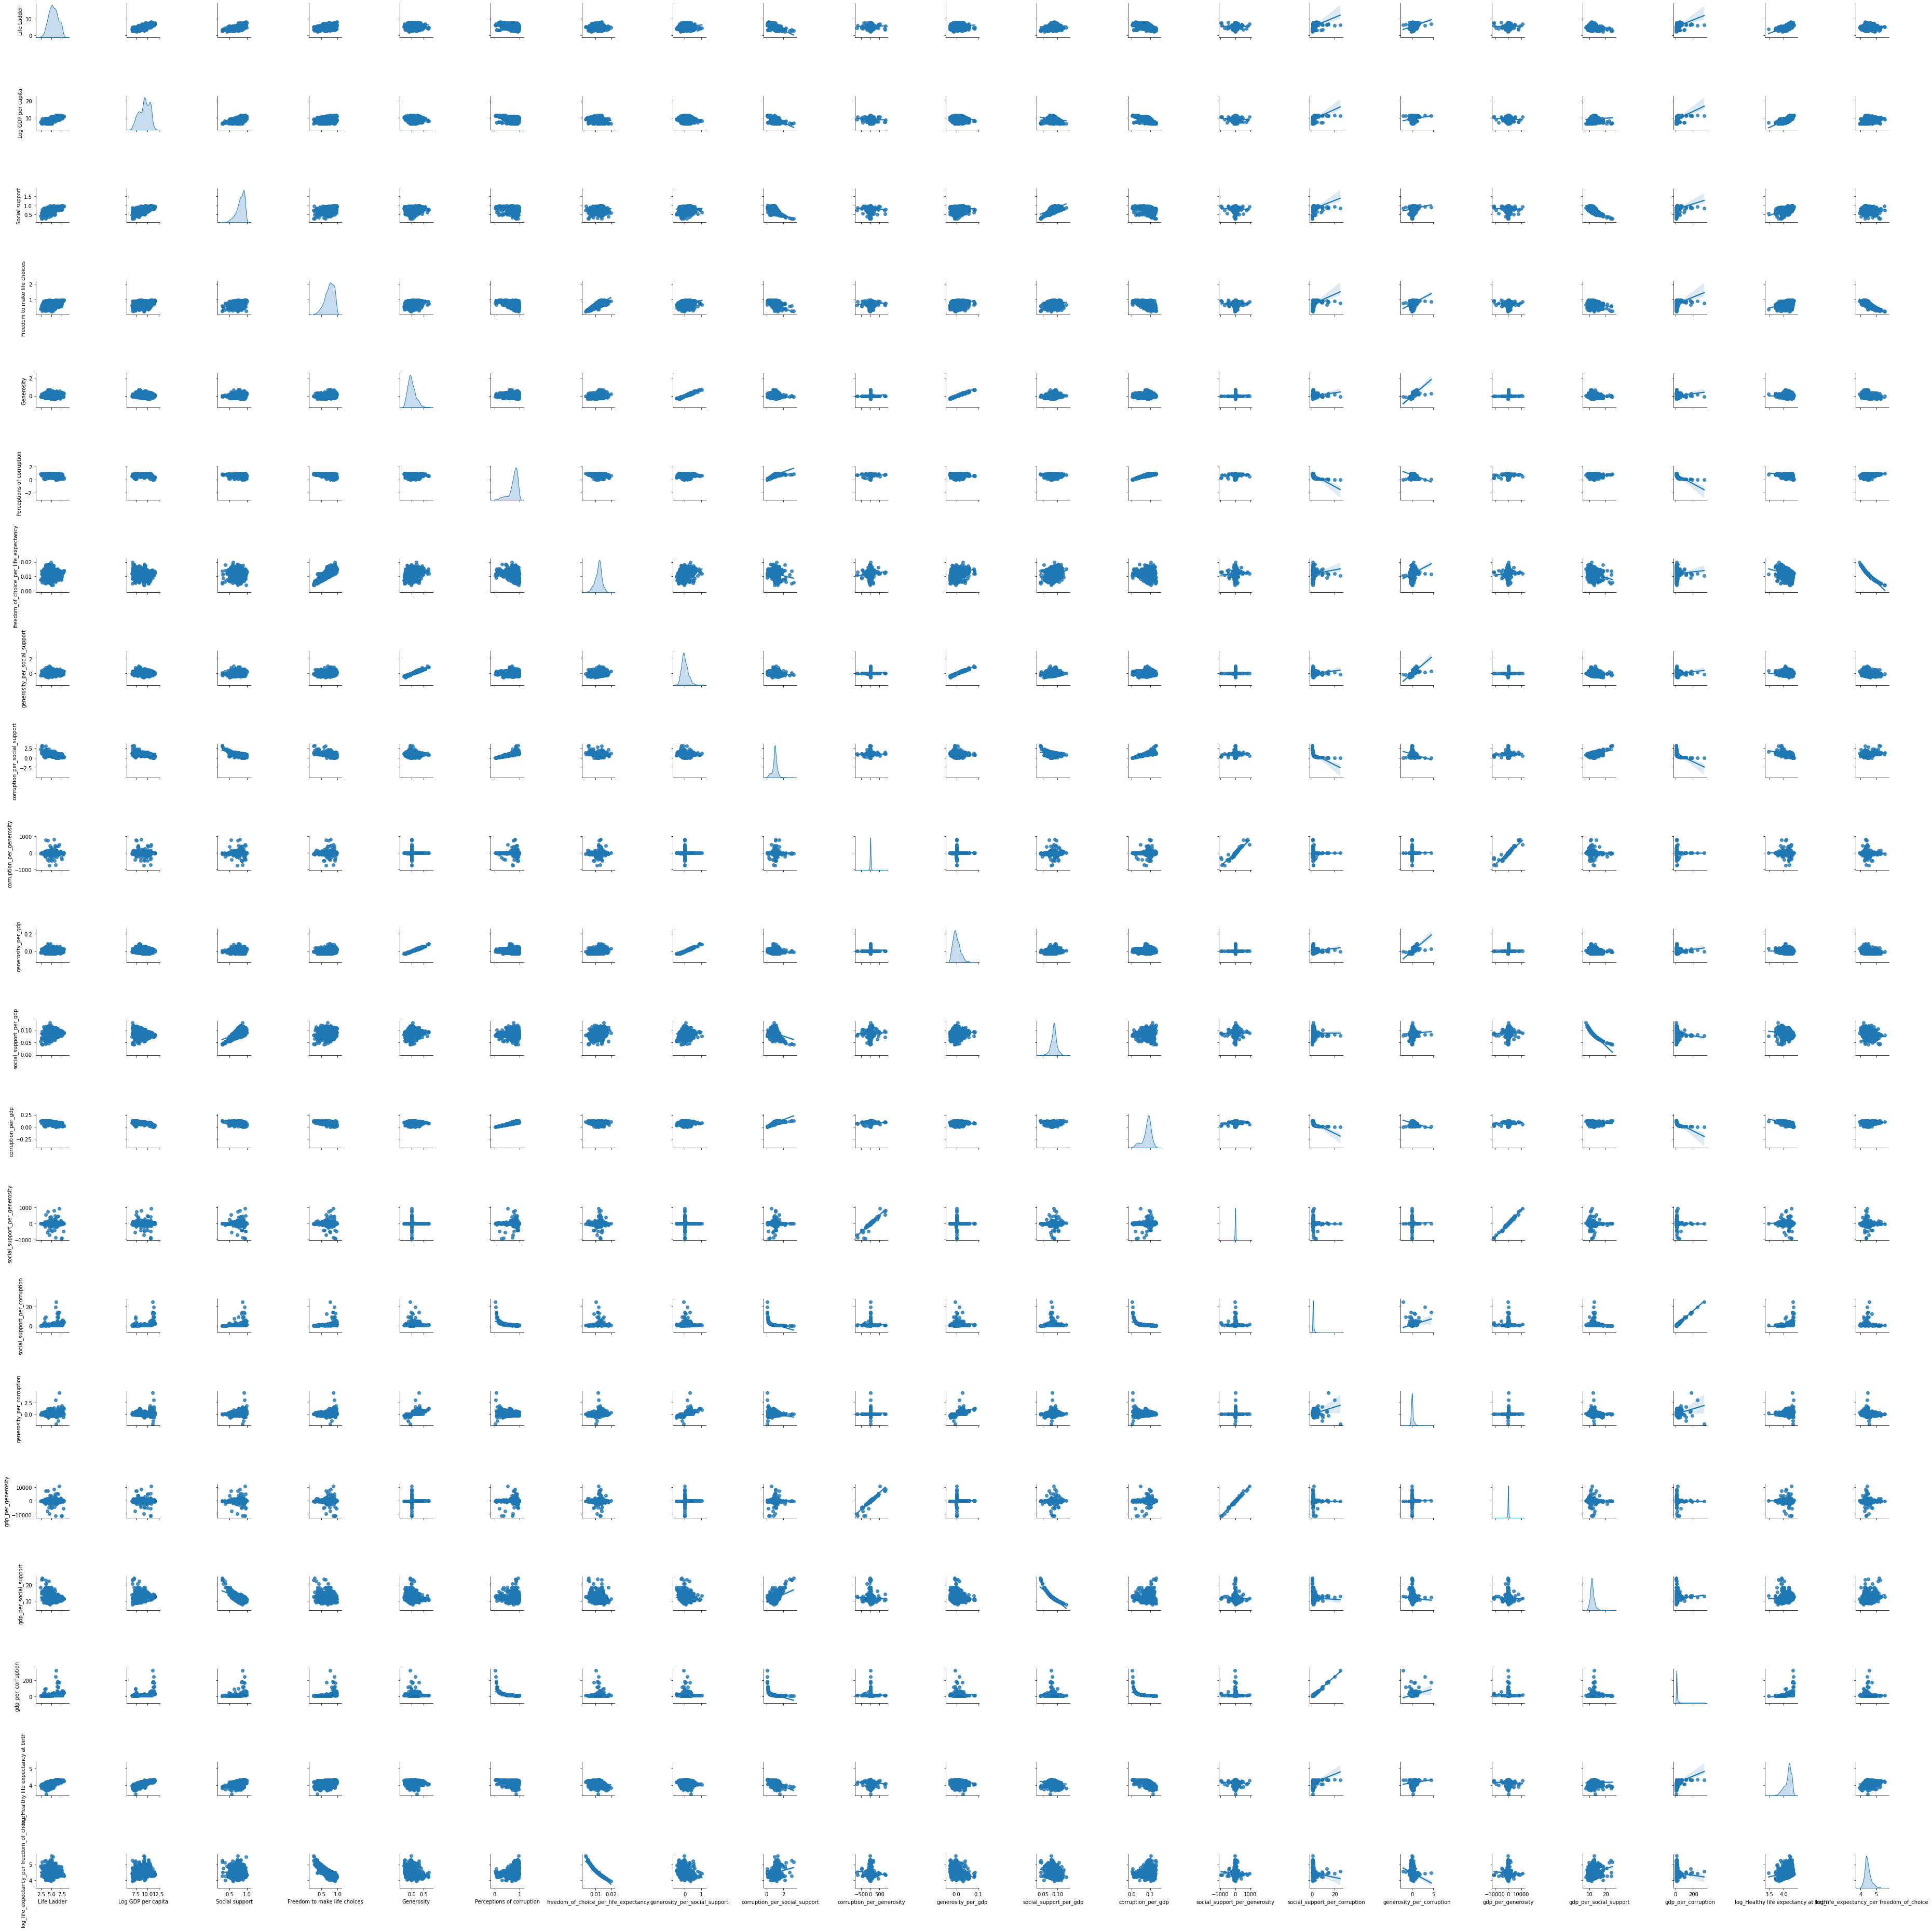

In [ ]:
# Regression plots for each column
train_dataset = X_train.copy()
train_dataset.insert(0, 'Life Ladder', y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

In [ ]:
# Create Linear Regression pipeline, fit the model, and generate r^2
lr = make_pipeline(
    SimpleImputer(missing_values=np.nan),
    StandardScaler(),
    LinearRegression() 
    )
# Fit the model
lr.fit(X_train, y_train)

# Apply the model to new data
y_pred_lr = lr.predict(X_train)

# R^2 Score
lr_accuracy = lr.score(X_val, y_val)
print('Linear Regression R^2:', lr_accuracy);

Linear Regression R^2: 0.7764453487646263


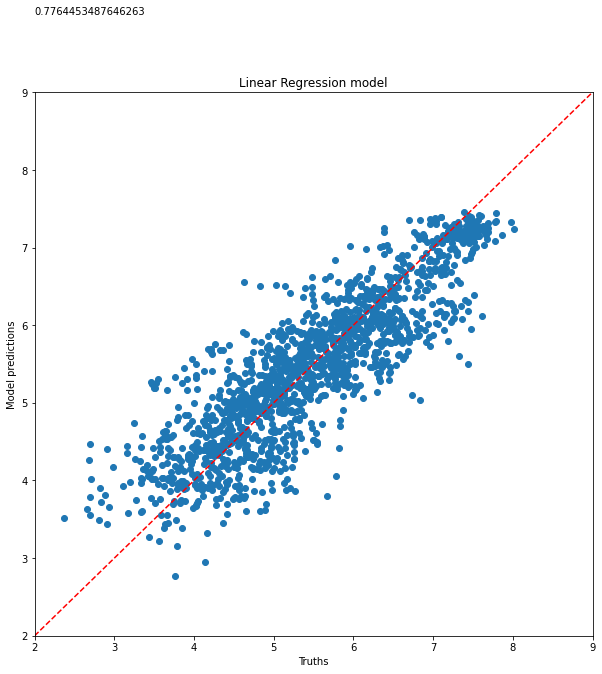

In [ ]:
# Comparing predictions to the training data
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(y_train, y_pred_lr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(2, 10, lr_accuracy)
plt.title('Linear Regression model')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([2, 9])
_ = plt.ylim([2, 9])

In [ ]:
# Generate the coefficients from the linear regression
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, X_val.columns).sort_values(ascending=False)

Social support                               0.668996
corruption_per_social_support                0.456758
Generosity                                   0.405813
Log GDP per capita                           0.339091
log_Healthy life expectancy at birth         0.275722
generosity_per_social_support                0.175231
corruption_per_gdp                           0.126052
corruption_per_generosity                    0.078863
gdp_per_generosity                           0.078491
social_support_per_corruption                0.040295
Freedom to make life choices                 0.029259
generosity_per_corruption                   -0.029594
freedom_of_choice_per_life_expectancy       -0.045512
gdp_per_corruption                          -0.126066
social_support_per_generosity               -0.129238
log_life_expectancy_per freedom_of_choice   -0.148440
gdp_per_social_support                      -0.191111
social_support_per_gdp                      -0.267657
generosity_per_gdp          

In [ ]:
# Test Random Forest Regression for better r^2 accuracy
rf = make_pipeline(
    SimpleImputer(missing_values=np.nan),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42) 
    )
# Fit the model
rf.fit(X_train, y_train)

# Apply the model to new data
y_pred_rf = rf.predict(X_train)

# R^2 Score
rf_accuracy = rf.score(X_val, y_val)
print('Random Forest R^2:', rf_accuracy)

Random Forest R^2: 0.8583989838187791


Validation Accuracy 0.8583989838187791


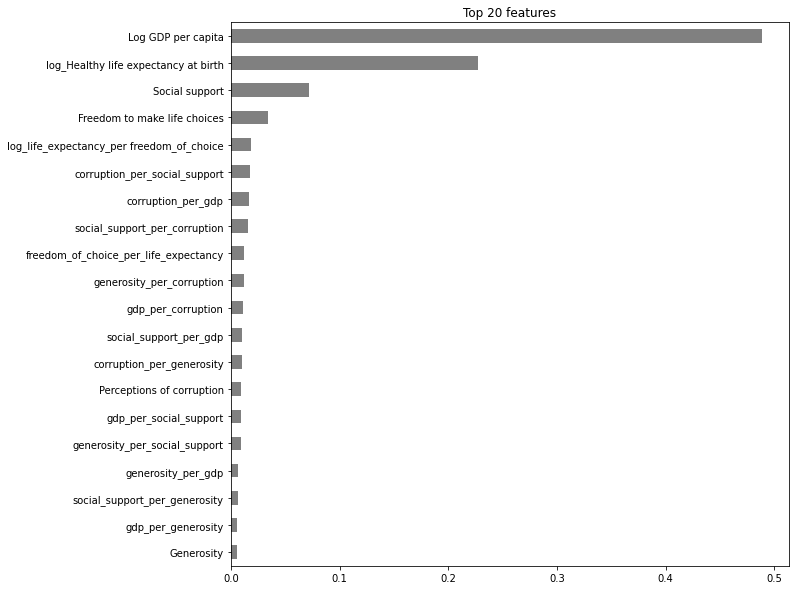

In [ ]:
# Fit on train, score on val
rf.fit(X_train, y_train)
print('Validation Accuracy', rf.score(X_val, y_val))

# Get feature importances
rf_names = rf.named_steps['randomforestregressor']
importances = pd.Series(rf_names.feature_importances_, X_train.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
# Permutation Importances tells me which columns I can drop based on how important they are.
permuter = PermutationImportance(
    rf, 
    scoring='r2', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

Log GDP per capita                           0.434180
log_Healthy life expectancy at birth         0.219300
Social support                               0.055974
Freedom to make life choices                 0.039724
log_life_expectancy_per freedom_of_choice    0.016268
corruption_per_social_support                0.013569
freedom_of_choice_per_life_expectancy        0.007939
social_support_per_corruption                0.007880
corruption_per_gdp                           0.007661
gdp_per_corruption                           0.004874
generosity_per_social_support                0.004497
generosity_per_corruption                    0.004380
generosity_per_gdp                           0.001959
corruption_per_generosity                    0.001775
Perceptions of corruption                    0.001762
gdp_per_social_support                       0.001703
Generosity                                   0.001313
social_support_per_gdp                       0.001066
gdp_per_generosity          

Drop the unimportant columns that are causing overfitting and rerun the models

In [ ]:
# Drop bottom 12 feature importance columns
df_fi_drop = df.drop(columns=['social_support_per_corruption',
        'gdp_per_corruption','corruption_per_gdp','gdp_per_social_support',
        'Perceptions of corruption','social_support_per_gdp',
        'generosity_per_social_support','generosity_per_gdp',
        'corruption_per_generosity','Generosity','social_support_per_generosity',
        'gdp_per_generosity','generosity_per_gdp',
        'social_support_per_generosity','Generosity'])

In [ ]:
df_fi_drop

,Life Ladder,Log GDP per capita,Social support,Freedom to make life choices,freedom_of_choice_per_life_expectancy,corruption_per_social_support,generosity_per_corruption,log_Healthy life expectancy at birth,log_life_expectancy_per freedom_of_choice
0,3.724,7.370,0.451,0.718,0.014134,1.955654,0.190476,3.927896,4.259182
1,4.402,7.540,0.552,0.679,0.013262,1.539855,0.223529,3.935740,4.322874
2,4.758,7.647,0.539,0.600,0.011628,1.311688,0.171146,3.943522,4.454347
3,3.832,7.620,0.521,0.496,0.009553,1.403071,0.221614,3.949704,4.650883
4,3.783,7.705,0.521,0.531,0.010165,1.489443,0.304124,3.955848,4.588842
...,...,...,...,...,...,...,...,...,...
1944,3.735,7.984,0.768,0.733,0.013474,0.942708,-0.131215,3.996364,4.306974
1945,3.638,8.016,0.754,0.753,0.013691,0.996021,-0.130493,4.007333,4.291023
1946,3.616,8.049,0.775,0.763,0.013723,1.089032,-0.080569,4.018183,4.288680
1947,2.694,7.950,0.759,0.632,0.011246,1.094862,-0.077016,4.028917,4.487783


In [ ]:
# Target vector (happiness)
X_fi_drop = df_fi_drop.drop(columns='Life Ladder')
y_fi_drop = df_fi_drop['Life Ladder']

# Train-test-split
X_fi_drop_train, X_fi_drop_val, y_fi_drop_train, y_fi_drop_val = train_test_split(X_fi_drop, y_fi_drop, train_size=.8)

# Baseline R^2
y_fi_drop_pred = [y_fi_drop_train.mean()] * len(y_fi_drop_train)
r2 = r2_score(y_fi_drop_train, y_fi_drop_pred)
print(f'R^2 Baseline: {r2:.4f} ')

R^2 Baseline: 0.0000 


In [ ]:
# Create Linear Regression pipeline, fit the model, and generate r^2
lr_fi_drop = make_pipeline(
    SimpleImputer(missing_values=np.nan),
    StandardScaler(),
    LinearRegression() 
    )
# Fit the model
lr_fi_drop.fit(X_fi_drop_train, y_fi_drop_train)

# Apply the model to new data
y_fi_drop_pred_lr = lr_fi_drop.predict(X_fi_drop_train)

# R^2 Score
lr_fi_drop_accuracy = lr_fi_drop.score(X_fi_drop_val, y_fi_drop_val)
print('Linear Regression R^2:', lr_fi_drop_accuracy);

Linear Regression R^2: 0.7554641129820845


In [ ]:
# Generate the coefficients from the linear regression
coefficients = lr_fi_drop.named_steps['linearregression'].coef_
pd.Series(coefficients, X_fi_drop_val.columns).sort_values(ascending=False)

Log GDP per capita                           0.438857
Freedom to make life choices                 0.249109
Social support                               0.245816
log_Healthy life expectancy at birth         0.154431
generosity_per_corruption                    0.112665
corruption_per_social_support               -0.031929
log_life_expectancy_per freedom_of_choice   -0.095951
freedom_of_choice_per_life_expectancy       -0.150287
dtype: float64

In [ ]:
# Test Random Forest Regression for better r^2 accuracy
rf_fi_drop = make_pipeline(
    SimpleImputer(missing_values=np.nan),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42) 
    )
# Fit the model
rf_fi_drop.fit(X_fi_drop_train, y_fi_drop_train)

# Apply the model to new data
y_fi_drop_pred_rf = rf_fi_drop.predict(X_fi_drop_train)

# R^2 Score
rf_fi_drop_training = rf_fi_drop.score(X_fi_drop_train, y_fi_drop_train)
rf_fi_drop_accuracy = rf_fi_drop.score(X_fi_drop_val, y_fi_drop_val)
print('Random Forest R^2 Training accuracy:', rf_fi_drop_training)
print('Random Forest R^2 Validation accuracy:', rf_fi_drop_accuracy)

Random Forest R^2 Training accuracy: 0.9779031228290522
Random Forest R^2 Validation accuracy: 0.850915633883578


That just removed over 1/2 of my columns and my performance got a slight increase. Now lets see if I can improve it more with more data wrangling, hyperperameter tuning, and gradient boosting.

In [ ]:
rf_fi_drop.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'randomforestregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [ ]:
# Hyperperameter tuning
param_distributions = {
    'simpleimputer__strategy': ['mean'], 
    'randomforestregressor__n_estimators': randint(50,500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__min_samples_split': randint(2,5),
    'randomforestregressor__bootstrap': 'False'    
}    

# If you're on Colab, decrease n_iter & cv parameters
rf_hyp = RandomizedSearchCV(
    rf_fi_drop, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring= 'r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

rf_hyp.fit(X_fi_drop_train, y_fi_drop_train);

print('Best hyperparameters', rf_hyp.best_params_)
print('Cross-validation R^2', rf_hyp.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2

Best hyperparameters {'randomforestregressor__bootstrap': 'a', 'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 454, 'simpleimputer__strategy': 'mean'}
Cross-validation R^2 0.8320658339520559


In [ ]:
# Gradient Boosting
xgb = make_pipeline(
    SimpleImputer(missing_values=np.nan), 
    XGBRegressor(n_estimators=100,
                 random_state=42,
                 objective='reg:squarederror',
                 n_jobs=-1,
                 booster='gbtree',
                 )
)

xgb.fit(X_fi_drop_train, y_fi_drop_train)
y_pred_xgb = xgb.predict(X_fi_drop_val)
#print('Gradient Boosting training R^2', r2_score(y_fi_drop_train, y_pred_xgb))
print('Gradient Boosting validation R^2', r2_score(y_fi_drop_val, y_pred_xgb))

Gradient Boosting validation R^2 0.8238496286357909


In [ ]:
xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'xgbregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__gamma', 'xgbregressor__importance_type', 'xgbregressor__learning_rate', 'xgbregressor__max_delta_step', 'xgbregressor__max_depth', 'xgbregressor__min_child_weight', 'xgbregressor__missing', 'xgbregressor__n_estimators', 'xgbregressor__n_jobs', 'xgbregressor__nthread', 'xgbregressor__objective', 'xgbregressor__random_state', 'xgbregressor__reg_alpha', 'xgbregressor__reg_lambda', 'xgbregressor__scale_pos_weight', 'xgbregressor__seed', 'xgbregressor__silent', 'xgbregressor__subsample', 'xgbregressor__verbosity'])

In [ ]:
# Gradient Boosting with hyperperameter tuning
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'mode'],     
    'xgbregressor__booster': ['gbtree'],    
    'xgbregressor__max_depth': [5, 10, 15, 20, None],
    'xgbregressor__n_estimators': randint(50,500),
    'xgbregressor__objective': ['reg:squarederror'],
    'xgbregressor__random_state': randint(0,100),
    'xgbregressor__n_jobs': [-1,0,1]
}    

# If you're on Colab, decrease n_iter & cv parameters
xgb_hyp = RandomizedSearchCV(
    xgb, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring= 'r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

xgb_hyp.fit(X_fi_drop_train, y_fi_drop_train);

print('Best hyperparameters', xgb_hyp.best_params_)
print('Cross-validation R^2', xgb_hyp.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0262s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0172s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.7548s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1661s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0195s.) Setting batch_size=4.
[Parallel(n_j

Best hyperparameters {'simpleimputer__strategy': 'mean', 'xgbregressor__booster': 'gbtree', 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 129, 'xgbregressor__n_jobs': -1, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 21}
Cross-validation R^2 0.8268940585221198


While close, even the gradient boosting with hyperperameter tuning is still less than my random forest model after dropping half of the features. However, the random forest with hyperperameter tuning model just edged out the random forest without hyperperameter tuning model. Now, lets build some graphs.

In [ ]:
# Test Random Forest Regression for better r^2 accuracy
rf_fi_drop = make_pipeline(
    SimpleImputer(missing_values=np.nan),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42) 
    )
# Fit the model
rf_fi_drop.fit(X_fi_drop_train, y_fi_drop_train)

# Apply the model to new data
y_fi_drop_pred_rf = rf_fi_drop.predict(X_fi_drop_train)

# R^2 Score
rf_fi_drop_accuracy = rf_fi_drop.score(X_fi_drop_val, y_fi_drop_val)
print('Random Forest R^2:', rf_fi_drop_accuracy)

Random Forest R^2: 0.850915633883578


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd01d3614d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd01d3680d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


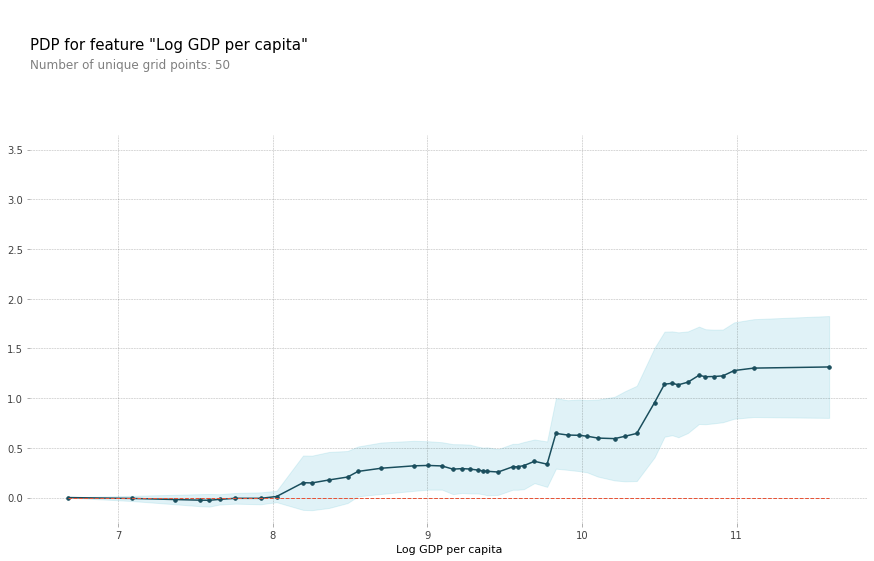

In [ ]:
# Partial Dependency Plot shows how the model performed at each branch of the 
# random forest for one feature
plt.rcParams['figure.dpi'] = 72

feature = 'Log GDP per capita'
isolated = pdp_isolate(
    model=rf_fi_drop, 
    dataset=X_fi_drop_val, 
    model_features=(X_fi_drop_val.columns),
    feature=feature,
    num_grid_points=50    
)

pdp_plot(isolated, feature_name=feature, frac_to_plot=0.01)
#plt.xlim((10000, 140000)); #zoom

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd01d382c50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd01c0baa50>})

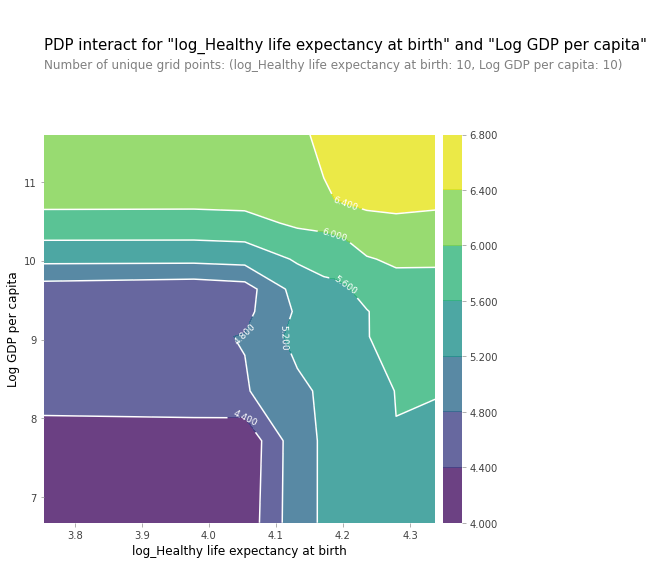

In [ ]:
# Comparing 2 features PDP
features = ['log_Healthy life expectancy at birth', 'Log GDP per capita']

interaction = pdp_interact(
    model=rf_fi_drop, 
    dataset=X_fi_drop_val, 
    model_features=X_fi_drop_val.columns,
    features=features
)

pdp_interact_plot(interaction, feature_names=features, plot_type='contour')

In [ ]:
# Principal Component Analysis
pca = PCA(n_components=8)
components = pca.fit_transform(X_fi_drop)

fig = px.scatter(components, x=0, y=1)
fig.show()

In [ ]:
# Boxplot comparing GDP and log healthy life expectancy: This graph wasn't helpful.
fig = px.box(X_fi_drop_val, x='log_Healthy life expectancy at birth', 
             y='Log GDP per capita', points='all')
fig.show()

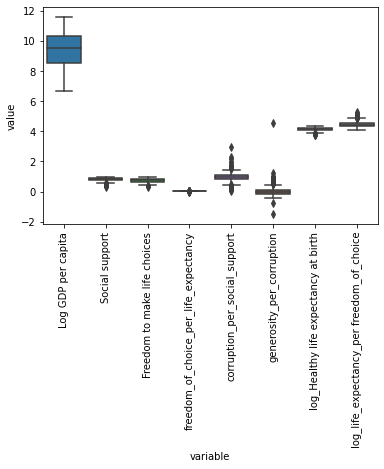

In [ ]:
# Boxplot of each feature after creating the log of 2 high value features
np.random.seed(42)
sns.boxplot(x="variable", y="value", data=pd.melt(X_fi_drop_val))
#sns.swarmplot(x="variable", y="value", data=pd.melt(X_fi_drop_val))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [ ]:
# Use Shap to visualize the impact each feature has on the target variable
shap_model = rf_fi_drop
explainer = shap.TreeExplainer(shap_model.named_steps["randomforestregressor"])
shap_values = explainer.shap_values(shap_model[:-1].transform(X_fi_drop_val))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_fi_drop_val.iloc[0,:])


In [ ]:
# Turn the testing file into a dataframe
df2 = pd.read_csv(test)

Now to apply my model to the test set. I need to wrangle my test set to match my training set first.

In [ ]:
# Data wrangling the test set to match the train and val set
# extra columns will need to be dropped from the test set.
# columns to drop:
df2.drop(columns=['Regional indicator','Standard error of ladder score','upperwhisker','lowerwhisker',
         'Ladder score in Dystopia','Explained by: Log GDP per capita',
         'Explained by: Social support','Explained by: Healthy life expectancy',
         'Explained by: Freedom to make life choices','Explained by: Generosity',
         'Explained by: Perceptions of corruption','Dystopia + residual'],inplace=True)

#Rename columns for clarity and consistency (compare to df)
df2.rename(columns={'Ladder score':'Life Ladder',
                   'Logged GDP per capita':'Log GDP per capita',
                   'Healthy life expectancy':'Healthy life expectancy at birth'}, inplace=True)

#Feature engineering
df2['freedom_of_choice_per_life_expectancy'] = df2['Freedom to make life choices'] / df2['Healthy life expectancy at birth']
df2['corruption_per_social_support'] = df2['Perceptions of corruption'] / df2['Social support']
df2['life_expectancy_per freedom_of_choice'] = df2['Healthy life expectancy at birth'] / df2['Freedom to make life choices']
df2['generosity_per_corruption'] = df2['Generosity'] / df2['Perceptions of corruption']

# Drop bottom feature importance columns
df2 = df2.drop(columns=['Perceptions of corruption','Generosity'])

# Remove dtype object column and categorical column'
df2 = df2.drop(columns='Country name')
df2 = df2.replace(to_replace=np.inf, value=np.nan)

# Convert each column's NaN values to the column 'mean' 
df2 = df2.replace(to_replace=np.inf, value=np.nan)
df2[['Log GDP per capita','Social support','Healthy life expectancy at birth',
     'Freedom to make life choices','freedom_of_choice_per_life_expectancy',
     'corruption_per_social_support','life_expectancy_per freedom_of_choice',
     'generosity_per_corruption']] = df2[['Log GDP per capita','Social support',
     'Healthy life expectancy at birth','Freedom to make life choices',
     'freedom_of_choice_per_life_expectancy','corruption_per_social_support',
     'life_expectancy_per freedom_of_choice',
     'generosity_per_corruption']].fillna(value=df2[['Log GDP per capita',
     'Social support','Healthy life expectancy at birth',
     'Freedom to make life choices','freedom_of_choice_per_life_expectancy',
     'corruption_per_social_support','life_expectancy_per freedom_of_choice',
     'generosity_per_corruption']].mean())

# Create log to normalize high value features and replace infinite values with 'NaN'
df2['log_Healthy life expectancy at birth'] = np.log(df2['Healthy life expectancy at birth'])
df2['log_life_expectancy_per freedom_of_choice'] = np.log(df2['life_expectancy_per freedom_of_choice'])
df2 = df2.drop(columns=['Healthy life expectancy at birth','life_expectancy_per freedom_of_choice'])



In [ ]:
pipeline = rf_hyp.best_estimator_

In [ ]:
X_test = df2.drop(columns='Life Ladder')
y_test = df2['Life Ladder']

y_pred_test = pipeline.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f'Test R^2: {test_r2:,}')

Test R^2: 0.9119464518991258


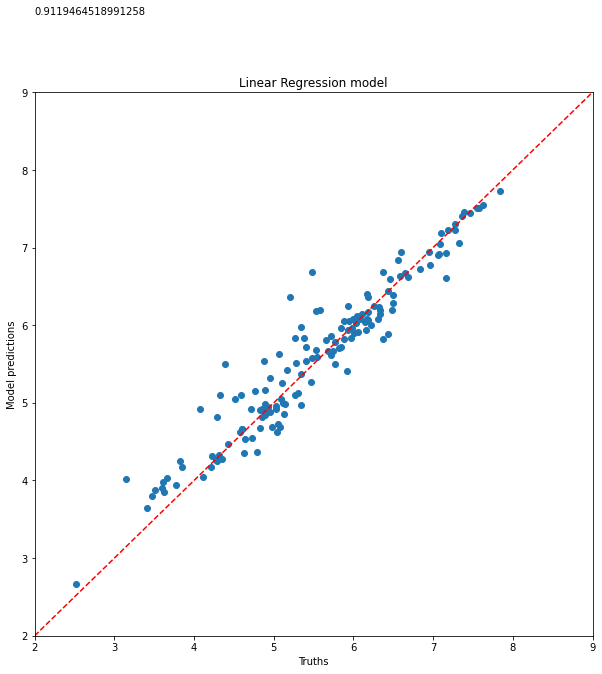

In [ ]:
# Comparing predictions to the testing data
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(y_test, y_pred_test)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(2, 10, test_r2)
plt.title('Linear Regression model')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([2, 9])
_ = plt.ylim([2, 9])

You can find a link to the blog post here: https://mattsdata.blogspot.com/search/label/World%20Happiness%20Report%202021
